In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import time
import random

c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\uti

In [2]:
torch.cuda.is_available()

True

In [3]:
RANDOM_SEED=42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCAB_SIZE=20000
LEARNING_RATE=0.005
BATCH_SIZE=128
EMBEDDING_DIM=128
NUM_EPOCHS=15
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_DIM=256
NUM_CLASSES=2
DEVICE

device(type='cuda')

In [4]:
tokenizer=get_tokenizer('spacy', language='en_core_web_sm')

In [5]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [6]:
class IMDBCSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        if 'review' not in self.data.columns or 'sentiment' not in self.data.columns:
            raise ValueError("CSV file must contain 'review' and 'sentiment' columns.")
        self.data['sentiment'] = self.data['sentiment'].map({'positive': 1, 'negative': 0})
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        sentiment = self.data.iloc[idx]['sentiment']
        return sentiment, review

In [7]:
dataset = IMDBCSVDataset(csv_file='IMDB Dataset.csv')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.85,0.15])

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 34000
Number of validation examples: 6000
Number of testing examples: 10000


In [8]:
vocab = build_vocab_from_iterator(
    yield_tokens(iter(train_dataset)),
    max_tokens=VOCAB_SIZE,
    specials=['<unk>', '<pad>']
)

In [9]:
def text_pipeline(text):
    tokens = tokenizer(text)
    indexed_tokens = [vocab[token] for token in tokens]
    return torch.tensor(indexed_tokens, dtype=torch.long)
def label_pipeline(label):
    return torch.tensor(label, dtype=torch.long)
def collate_fn(batch):
    text_list, label_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)
    padded_texts = pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])
    
    return padded_texts, torch.tensor(label_list)

In [10]:
vocab.set_default_index(vocab['<unk>'])

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [12]:
# --- Model Definition ---

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim,batch_first=True) # Set batch_first=True
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = hidden[-1]
        
        out = self.fc(hidden)
        
        return out

# --- Training and Evaluation Functions ---
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    return correct_predictions * 100.00 / total_predictions

# --- Training Process ---
torch.manual_seed(RANDOM_SEED)
model = RNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

start = time.time()
print("Training started...")
train_accs=[]
val_accs=[]
for epoch in range(NUM_EPOCHS):
    model.train()
    for i,(features,labels) in enumerate(train_loader):
        features=features.to(DEVICE)
        labels=labels.to(DEVICE).long()
        optimizer.zero_grad()
        outputs=model(features)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_acc=compute_accuracy(model,train_loader,DEVICE)
        val_acc=compute_accuracy(model,val_loader,DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')
    print(f'Time elapsed: {time.time()-start:.2f} seconds')


print('Test Accuracy: {:.2f}%'.format(compute_accuracy(model,test_loader,DEVICE)))

Training started...
Epoch: 1, Loss: 0.6906, Train Accuracy: 50.04%, Validation Accuracy: 49.28%
Time elapsed: 119.03 seconds
Epoch: 2, Loss: 0.6947, Train Accuracy: 50.13%, Validation Accuracy: 50.82%
Time elapsed: 241.20 seconds
Epoch: 3, Loss: 0.6880, Train Accuracy: 50.14%, Validation Accuracy: 49.32%
Time elapsed: 363.63 seconds
Epoch: 4, Loss: 0.6889, Train Accuracy: 50.14%, Validation Accuracy: 49.28%
Time elapsed: 490.14 seconds
Epoch: 5, Loss: 0.6964, Train Accuracy: 50.21%, Validation Accuracy: 50.73%
Time elapsed: 612.88 seconds
Epoch: 6, Loss: 0.6945, Train Accuracy: 50.18%, Validation Accuracy: 49.23%
Time elapsed: 739.20 seconds
Epoch: 7, Loss: 0.6895, Train Accuracy: 50.24%, Validation Accuracy: 49.33%
Time elapsed: 864.53 seconds
Epoch: 8, Loss: 0.6940, Train Accuracy: 58.70%, Validation Accuracy: 58.30%
Time elapsed: 989.53 seconds
Epoch: 9, Loss: 0.3799, Train Accuracy: 84.59%, Validation Accuracy: 81.32%
Time elapsed: 1112.52 seconds
Epoch: 10, Loss: 0.3866, Train Acc

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

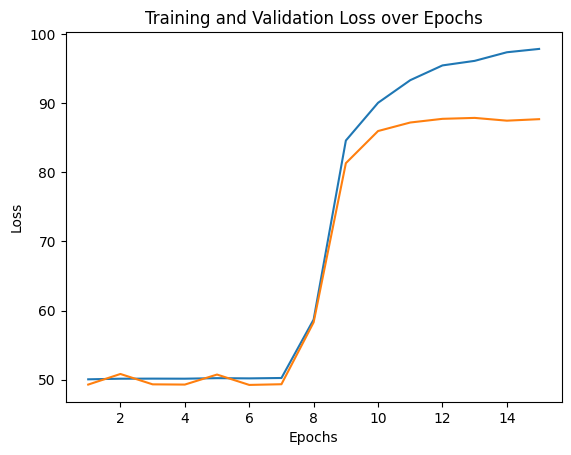

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')